In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf

def split_data(df, train_size):
    train_data = df[:train_size]
    test_data = df[train_size:]
    print("Train: ", len(train_data))
    print("Test: ", len(test_data))
    return train_data, test_data

df = pd.read_csv('../../Data/DOGE-USD.csv', usecols=[0, 4], parse_dates=[0], index_col=0)
print(df.head())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

               Close
Date                
2019-03-01  0.001994
2019-03-02  0.002003
2019-03-03  0.001999
2019-03-04  0.001982
2019-03-05  0.001985


In [2]:
# Tạo hàm input sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

def build_and_train_model(X_train, y_train, X_test, y_test, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    return model

def mae_rmse_mape(true, predict):
    mae = mean_absolute_error(true, predict)
    rmse = np.sqrt(mean_squared_error(true, predict))
    mape = mean_absolute_percentage_error(true, predict)
    mse = mean_squared_error(true, predict)
    return mae, rmse, mape, mse


In [3]:
def predict_future(model, X_test, days_to_predict):
    last_sequence = X_test[-1:]
    predicted_values = []

    for _ in range(days_to_predict):
        next_value = model.predict(last_sequence)
        predicted_values.append(next_value[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)

    return predicted_values

In [4]:
# define the number of time steps and features

n_steps = 10
n_features = 1
ratios = [0.6, 0.7, 0.8]

results = {}

In [5]:
for ratio in ratios:
    train_size = int(len(scaled_data) * ratio)
    train_data, test_data = split_data(scaled_data, train_size)
    
    X_train, y_train = create_sequences(train_data, n_steps)
    X_test, y_test = create_sequences(test_data, n_steps)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    
    model = build_and_train_model(X_train, y_train, X_test, y_test, n_steps, n_features)
    
    y_pred_test = model.predict(X_test)
    y_pred_test = scaler.inverse_transform(y_pred_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    
    mae_test, rmse_test, mape_test, mse_test = mae_rmse_mape(y_test, y_pred_test)
    
    predicted_values_30 = predict_future(model, X_test, 30)
    predicted_values_60 = predict_future(model, X_test, 60)
    predicted_values_90 = predict_future(model, X_test, 90)
    
    predicted_values_30 = scaler.inverse_transform(np.array(predicted_values_30).reshape(-1, 1))
    predicted_values_60 = scaler.inverse_transform(np.array(predicted_values_60).reshape(-1, 1))
    predicted_values_90 = scaler.inverse_transform(np.array(predicted_values_90).reshape(-1, 1))
    
    results[ratio] = {
        'model': model,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'mae_test': mae_test,
        'rmse_test': rmse_test,
        'mape_test': mape_test,
        'mse_test': mse_test,
        'predicted_values_30': predicted_values_30,
        'predicted_values_60': predicted_values_60,
        'predicted_values_90': predicted_values_90
    }

Train:  1152
Test:  768
Epoch 1/100


d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0235 - val_loss: 3.9699e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 2.6315e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 2.6448e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 2.8527e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 2.2132e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 4.8482e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 2.3934e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 1.9225e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 3.4312e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 2.4468e-04
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6467e-04 - val_loss: 1.5980e-04
Epoch 12/100
36/36 ━

d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0181 - val_loss: 2.8438e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 6.3690e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 2.1648e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 3.0142e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 2.9756e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 1.8560e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 4.0446e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 1.6300e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 1.6851e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 2.6348e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 1.7638e-04
Epoch 12/100
42/42 ━━━━━━━━━━━

d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0161 - val_loss: 3.1664e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 6.9826e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 6.5501e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 2.7797e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 2.4775e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 2.4630e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 2.2607e-04
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6956e-04 - val_loss: 1.9910e-04
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0000e-04 - val_loss: 2.1205e-04
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 1.8288e-04
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2851e-04 - val_loss: 2.0915e-04
Epoch 12/100
48/48

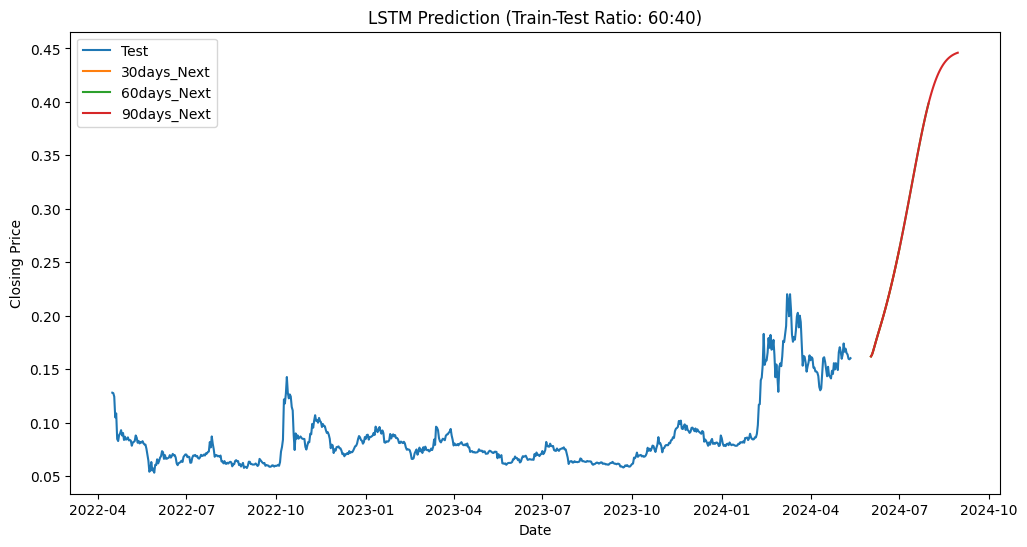

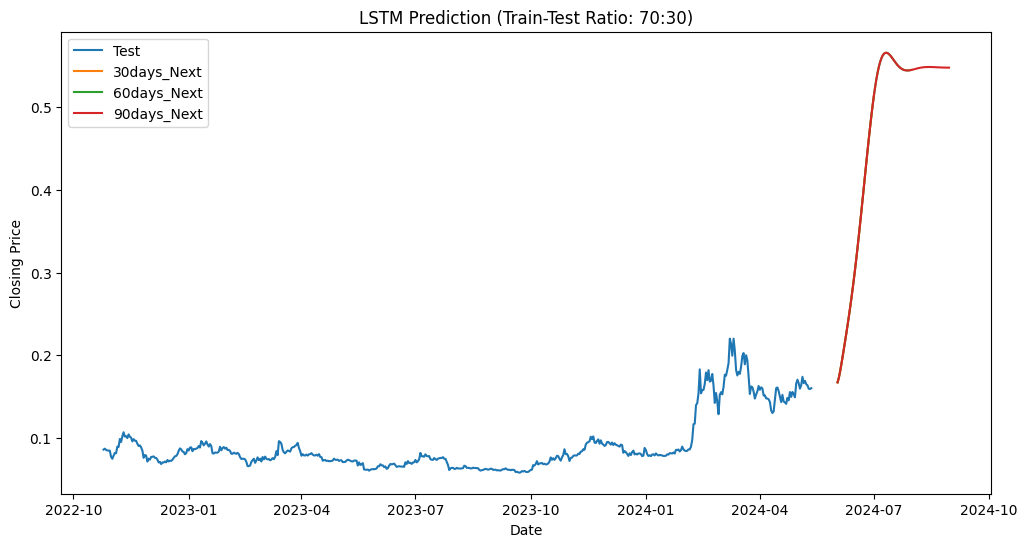

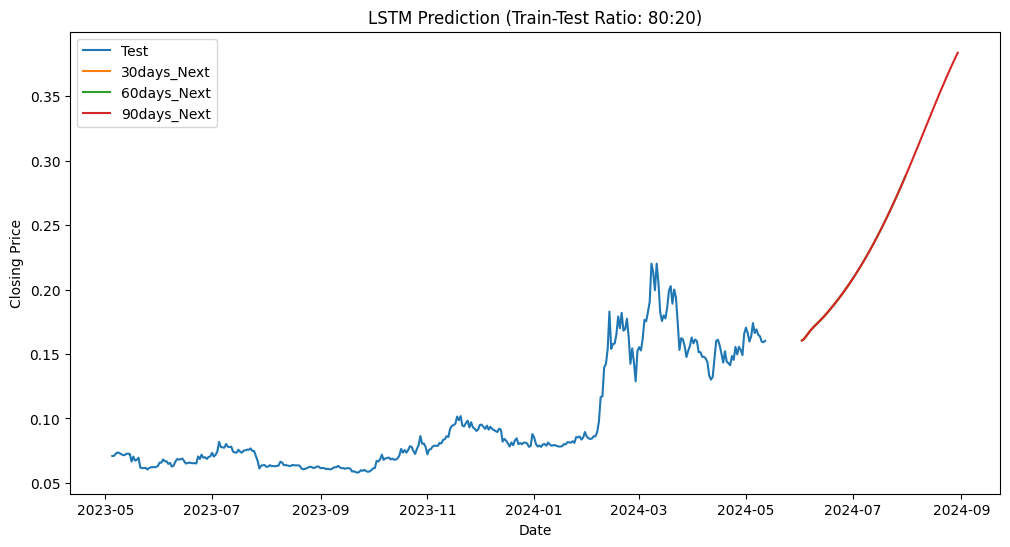

In [6]:
for ratio, result in results.items():
    plt.figure(figsize=(12, 6))
    #plt.plot(df.index[:len(result['y_train'])], result['y_train'], label='Train')
    plt.plot(df.index[len(result['y_train']):len(result['y_train']) + len(result['y_test'])], result['y_test'], label='Test')
    #plt.plot(df.index[len(result['y_train']):len(result['y_train']) + len(result['y_test'])], result['y_pred_test'], label='Test Prediction')

    future_dates_30 = pd.date_range(df.index[-1], periods=30+1)[1:]
    future_dates_60 = pd.date_range(df.index[-1], periods=60+1)[1:]
    future_dates_90 = pd.date_range(df.index[-1], periods=90+1)[1:]
    
    plt.plot(future_dates_30, result['predicted_values_30'], label='30days_Next')
    plt.plot(future_dates_60, result['predicted_values_60'], label='60days_Next')
    plt.plot(future_dates_90, result['predicted_values_90'], label='90days_Next')

    plt.title(f'LSTM Prediction (Train-Test Ratio: {ratio * 100:.0f}:{(1 - ratio) * 100:.0f})')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()


In [7]:
for ratio, result in results.items():
    print(f"Results for Train-Test ratio {ratio * 100:.0f}:{(1 - ratio) * 100:.0f}")
    print(f"MAE: {result['mae_test']}")
    print(f"RMSE: {result['rmse_test']}")
    print(f"MAPE: {result['mape_test']}")
    print(f"MSE: {result['mse_test']}")
    print()
    print("Predicted values for next 30 days:")
    print(result['predicted_values_30'])
    print()
    print("Predicted values for next 60 days:")
    print(result['predicted_values_60'])
    print()
    print("Predicted values for next 90 days:")
    print(result['predicted_values_90'])
    print()

Results for Train-Test ratio 60:40
MAE: 0.0036974684677092565
RMSE: 0.005862186243238875
MAPE: 0.04032648873990949
MSE: 3.436522755041912e-05

Predicted values for next 30 days:
[[0.16187401]
 [0.16337481]
 [0.16609327]
 [0.16922367]
 [0.17245544]
 [0.17569958]
 [0.17886735]
 [0.18198633]
 [0.18505782]
 [0.18811604]
 [0.19117756]
 [0.19426957]
 [0.19741952]
 [0.20063536]
 [0.20392463]
 [0.20729044]
 [0.21073273]
 [0.2142499 ]
 [0.21783993]
 [0.22150098]
 [0.22523187]
 [0.22903185]
 [0.23290072]
 [0.23683861]
 [0.24084564]
 [0.24492195]
 [0.24906746]
 [0.25328168]
 [0.2575637 ]
 [0.26191232]]

Predicted values for next 60 days:
[[0.16187401]
 [0.16337481]
 [0.16609327]
 [0.16922367]
 [0.17245544]
 [0.17569958]
 [0.17886735]
 [0.18198633]
 [0.18505782]
 [0.18811604]
 [0.19117756]
 [0.19426957]
 [0.19741952]
 [0.20063536]
 [0.20392463]
 [0.20729044]
 [0.21073273]
 [0.2142499 ]
 [0.21783993]
 [0.22150098]
 [0.22523187]
 [0.22903185]
 [0.23290072]
 [0.23683861]
 [0.24084564]
 [0.24492195]
 